In [18]:
import torch
from torch.utils.data import DataLoader
from dataset import YoloDarknetDataset
from model import model_builder
import lightnet as ln
from test_script import test_step
from utils import plot_result, RGBDCustomTransform, RGBCustomTransform, DepthCustomTransform, load_config, to_xyxy_coords, draw_bounding_boxes

In [19]:
config = load_config("configs/train_anyv2_local_pavic.yaml")


BASE_DIR = config["base_dir"]
TRAIN_IMG_DIR = config["train_img_dir"]
TRAIN_DEPTH_DIR = config["train_depth_dir"]
TRAIN_LABEL_DIR =  config["train_label_dir"]
BATCH_SIZE = config["batch_size"]
NUM_WORKERS = config["num_workers"]
LEARNING_RATE = config["learning_rate"]
NUM_EPOCHS = config["num_epochs"]
MODEL_TYPE = config["model_type"]
FUSE_LAYER = config["fuse_layer"]
DATASET_NAME = config["dataset_name"]
TEST_IMG_DIR = config["test_img_dir"]
TEST_DEPTH_DIR = config["test_depth_dir"]
TEST_LABEL_DIR = config["test_label_dir"]

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = 3

TRAIN_IMG_DIR =  BASE_DIR + TRAIN_IMG_DIR
TRAIN_DEPTH_DIR = BASE_DIR + TRAIN_DEPTH_DIR
TRAIN_LABEL_DIR = BASE_DIR + TRAIN_LABEL_DIR

In [20]:
print(f"Using Configuration \n{config}")
print(f"Using Device {DEVICE}")


model = model_builder(num_classes=NUM_CLASSES, model_type=MODEL_TYPE, fuse_layer=FUSE_LAYER)
model.load("models/anythingv2_best.pth")
model.to("cpu")

loss_fn = ln.network.loss.RegionLoss(
    num_classes= model.num_classes,
    anchors=model.anchors,
    network_stride=model.stride
)

test_transforms = RGBCustomTransform(resize_size=(416, 416), flip_prob=.5)

test_dataset = YoloDarknetDataset(
    images_dir=TEST_IMG_DIR,
    depth_dir=TEST_DEPTH_DIR,
    labels_dir=TEST_LABEL_DIR,
    classes=["Cyclist", "Pedestrian", "Car"],
    transform=test_transforms,
    model_type=MODEL_TYPE
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

Using Configuration 
{'dataset_name': 'anythingv2_newsplit', 'base_dir': '/home/gkmo/workspace/data', 'train_img_dir': '/home/gustavo/workstation/depth_estimation/data/new_splits/train/images/', 'train_depth_dir': '/home/gustavo/workstation/depth_estimation/data/new_anything_split/train/', 'train_label_dir': '/home/gustavo/workstation/depth_estimation/data/new_splits/train/labels/', 'val_img_dir': '/home/gustavo/workstation/depth_estimation/data/new_splits/val/images/', 'val_depth_dir': '/home/gustavo/workstation/depth_estimation/data/new_anything_split/val/', 'val_label_dir': '/home/gustavo/workstation/depth_estimation/data/new_splits/val/labels/', 'test_img_dir': '/home/gustavo/workstation/depth_estimation/data/new_splits/test/images/', 'test_depth_dir': '/home/gustavo/workstation/depth_estimation/data/new_anything_split/test/', 'test_label_dir': '/home/gustavo/workstation/depth_estimation/data/new_splits/test/labels/', 'batch_size': 16, 'num_workers': 16, 'learning_rate': 0.01, 'num

/home/gustavo/workstation/depth_estimation/codes/rgbd-yolov2/.venv/lib/python3.10/site-packages/lightnet/network/module/_lightnet.py:293: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental 

In [21]:
do_test = False
if do_test:
    metric_map, test_loss= test_step(
        model=model,
        dataloader=test_dataloader,
        batch_size=BATCH_SIZE,
        loss_fn=loss_fn,
        device=DEVICE
    )

    print(f"mAP | AP {metric_map}")
    print(f"Test Loss: {test_loss}")

In [22]:
#plot_result(model=model, test_dataset=test_dataset, index=3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


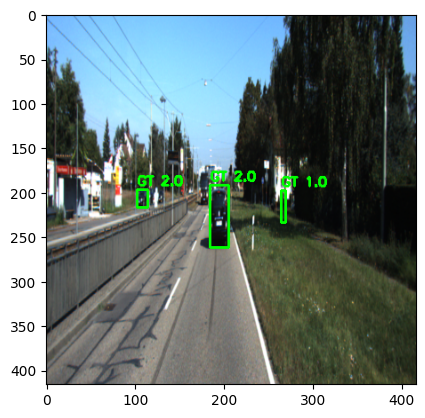

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

image, target = test_dataset[3]
boxes = target["boxes"]
true_boxes = []

for _, boxes in enumerate(boxes):

    if boxes[0].item() == -1: #supress the padding
        continue
    # works with xyxy coords only!
    #x1, y1, x2, y2 = box[1:]*416
    x1, y1, x2, y2 = to_xyxy_coords(boxes[1:], 416, 416)
    # add image index on the list

    true_box = [0, boxes[0].item(), 1, x1.item(), y1.item(), x2.item(), y2.item()] 
    true_boxes.append(true_box)

image_array = image.permute(1, 2, 0).cpu().numpy()
image_copy = image_array.copy()
# Draw ground truth bounding boxes (Green)
for box in true_boxes:
    _, class_index,_,  x1, y1, x2, y2 = box
    cv2.rectangle(image_copy, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
    label = f"GT {class_index}"
    cv2.putText(image_copy, label, (int(x1), int(y1) - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)


plt.imshow(image_copy)